<a href="https://colab.research.google.com/github/sappw1/Dissertation/blob/main/Notebooks/Working/Modeling/05_TSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun May 18 17:25:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
import os, json, cupy as cp
from cuml.manifold import TSNE
from time import time

In [3]:
# Mount Drive
drive.mount('/content/drive')

# Paths
base_dir = "/content/drive/MyDrive/NCU/Dissertation/Data/Processed/Clustering"
pca_dir = os.path.join(base_dir, "PCA")
tsne_dir = os.path.join(base_dir, "TSNE")
os.makedirs(tsne_dir, exist_ok=True)

Mounted at /content/drive


In [4]:
# Configs
tsne_configs = {
    "x_all_pca_2": {"input": "x_all_pca_2.npy", "output_2d": "x_all_tsne_2d.npy", "output_3d": "x_all_tsne_3d.npy"},
    "x_key_pca_2": {"input": "x_key_pca_2.npy", "output_2d": "x_key_tsne_2d.npy", "output_3d": "x_key_tsne_3d.npy"},
}

In [6]:

# T-SNE params
perplexity = 50
n_iter = 2000
results = {}

# Run T-SNE
for key, cfg in tsne_configs.items():
    print(f"Processing {key}...")
    X = cp.load(os.path.join(pca_dir, cfg["input"]))
    results[key] = {}

    for dim in [2]:
        print(f"  → Running T-SNE ({dim}D)...")
        tsne = TSNE(n_components=dim, perplexity=perplexity, n_iter=n_iter, verbose=1)
        start = time()
        X_tsne = tsne.fit_transform(X)
        end = time()

        out_name = cfg.get(f"output_{dim}d", f"{key.replace('pca', 'tsne')}_{dim}d.npy")
        cp.save(os.path.join(tsne_dir, out_name), X_tsne)

        results[key][f"{dim}d"] = {
            "shape": list(X_tsne.shape),
            "perplexity": perplexity,
            "n_iter": n_iter,
            "runtime_sec": round(end - start, 2)
        }

# Save JSON
with open(os.path.join(tsne_dir, "tsne_results.json"), "w") as f:
    json.dump(results, f, indent=4)

print(" T-SNE complete. Projections and results saved.")

Processing x_all_pca_2...
  → Running T-SNE (2D)...
Processing x_key_pca_2...
  → Running T-SNE (2D)...
 T-SNE complete. Projections and results saved.


Mounted at /content/drive


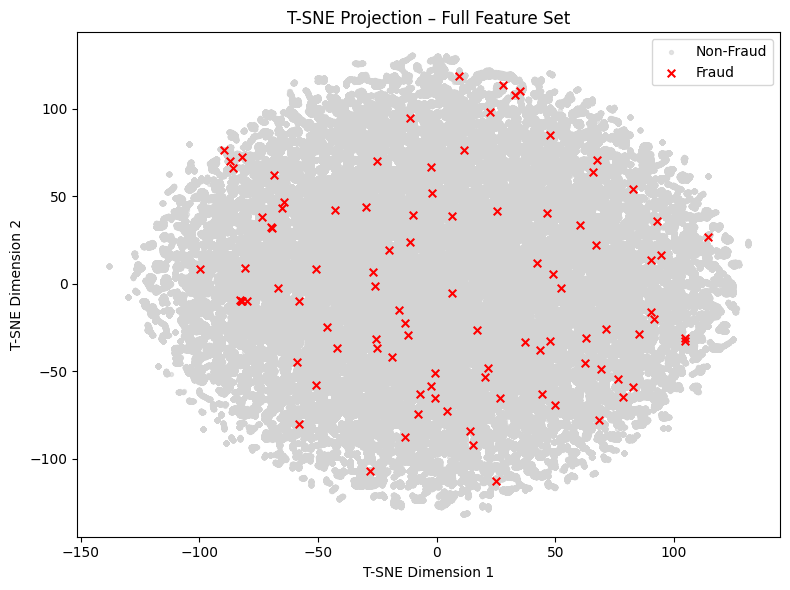

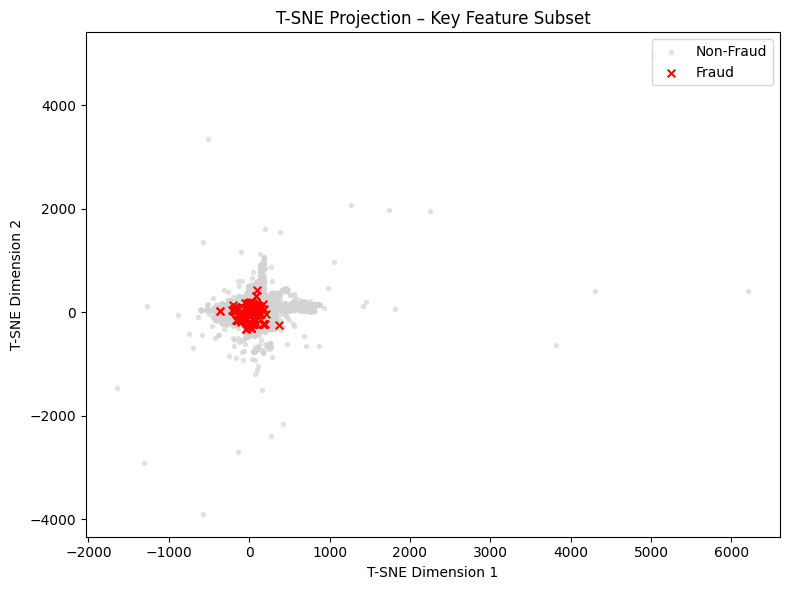

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive

# Mount and set paths
drive.mount('/content/drive')

base_dir = "/content/drive/MyDrive/NCU/Dissertation/Data/Processed/Clustering"
tsne_dir = os.path.join(base_dir, "TSNE")
fig_dir = "/content/drive/MyDrive/NCU/Dissertation/Figures/TSNEPlots"
os.makedirs(fig_dir, exist_ok=True)

# Load projections
X_all = np.load(os.path.join(tsne_dir, "x_all_tsne_2d.npy"))
X_key = np.load(os.path.join(tsne_dir, "x_key_tsne_2d.npy"))

# Load fraud labels and indices
y = pd.read_pickle(os.path.join(base_dir, "y_labels.pkl"))
idx_all = pd.read_csv(os.path.join(base_dir, "index_all_scaled.csv"), index_col=0).index
idx_key = pd.read_csv(os.path.join(base_dir, "index_key_scaled.csv"), index_col=0).index

y_all = y.loc[idx_all].values
y_key = y.loc[idx_key].values

# Plot function
def plot_tsne_overlay(x, y_true, title, save_name):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(x[y_true == 0, 0], x[y_true == 0, 1], c='lightgray', s=8, label='Non-Fraud', alpha=0.6)
    ax.scatter(x[y_true == 1, 0], x[y_true == 1, 1], c='red', marker='x', s=30, label='Fraud', zorder=2)

    ax.set_xlabel("T-SNE Dimension 1")
    ax.set_ylabel("T-SNE Dimension 2")
    ax.set_title(title)
    ax.legend(loc='upper right', fontsize='medium')
    plt.tight_layout()

    out_path = os.path.join(fig_dir, save_name)
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

# Generate plots
plot_tsne_overlay(X_all, y_all, "T-SNE Projection – Full Feature Set", "tsne_all_overlay.png")
plot_tsne_overlay(X_key, y_key, "T-SNE Projection – Key Feature Subset", "tsne_key_overlay.png")


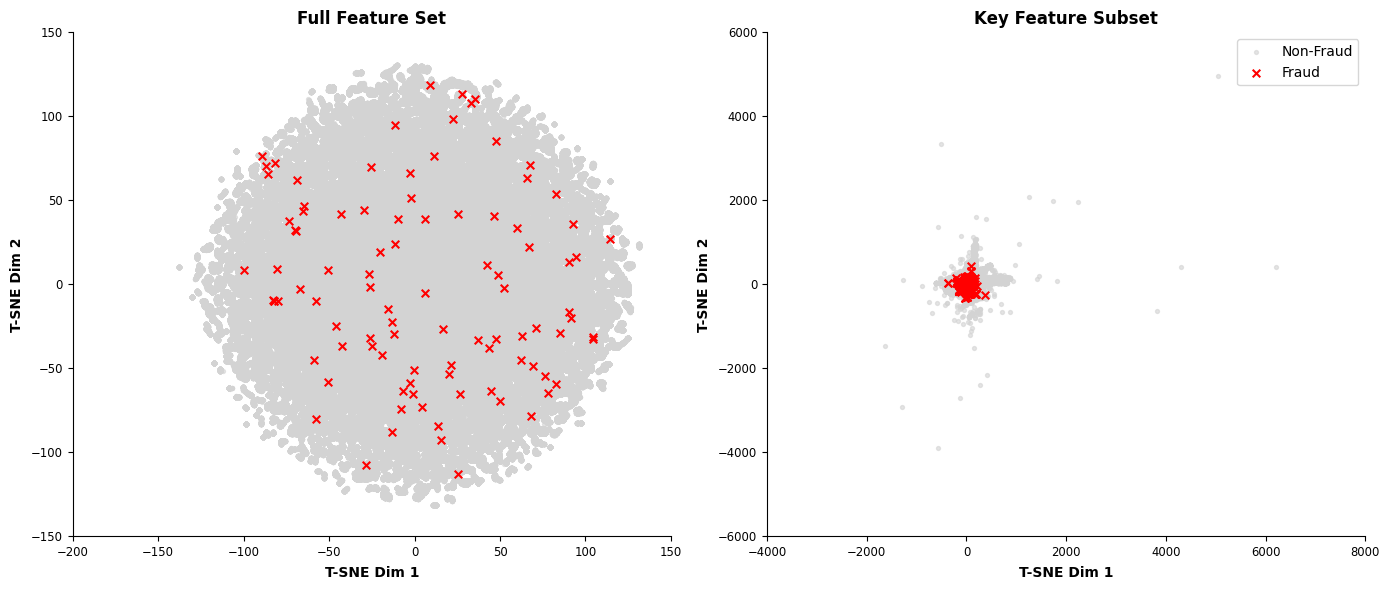

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paths
base_dir = "/content/drive/MyDrive/NCU/Dissertation/Data/Processed/Clustering"
tsne_dir = os.path.join(base_dir, "TSNE")
fig_dir = "/content/drive/MyDrive/NCU/Dissertation/Figures/TSNEPlots"
os.makedirs(fig_dir, exist_ok=True)

# Load projections
X_all = np.load(os.path.join(tsne_dir, "x_all_tsne_2d.npy"))
X_key = np.load(os.path.join(tsne_dir, "x_key_tsne_2d.npy"))

# Load fraud labels and indices
y = pd.read_pickle(os.path.join(base_dir, "y_labels.pkl"))
idx_all = pd.read_csv(os.path.join(base_dir, "index_all_scaled.csv"), index_col=0).index
idx_key = pd.read_csv(os.path.join(base_dir, "index_key_scaled.csv"), index_col=0).index

y_all = y.loc[idx_all].values
y_key = y.loc[idx_key].values

# APA-style figure
plt.style.use("/content/drive/MyDrive/NCU/Dissertation/apa.mplstyle")

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=False, sharey=False)

# Plot: Full Feature Set
axs[0].scatter(X_all[y_all == 0, 0], X_all[y_all == 0, 1], c='lightgray', s=8, label='Non-Fraud', alpha=0.6)
axs[0].scatter(X_all[y_all == 1, 0], X_all[y_all == 1, 1], c='red', marker='x', s=30, label='Fraud', zorder=2)
axs[0].set_title("Full Feature Set", fontsize=12)
axs[0].set_xlabel("T-SNE Dim 1")
axs[0].set_ylabel("T-SNE Dim 2")

# Plot: Key Feature Subset
axs[1].scatter(X_key[y_key == 0, 0], X_key[y_key == 0, 1], c='lightgray', s=8, alpha=0.6)
axs[1].scatter(X_key[y_key == 1, 0], X_key[y_key == 1, 1], c='red', marker='x', s=30, zorder=2)
axs[1].set_title("Key Feature Subset", fontsize=12)
axs[1].set_xlabel("T-SNE Dim 1")
axs[1].set_ylabel("T-SNE Dim 2")

# Shared legend in second panel
handles, labels = axs[0].get_legend_handles_labels()
axs[1].legend(handles, labels, loc='upper right', fontsize='medium')

plt.tight_layout()
save_path = os.path.join(fig_dir, "tsne_composite_overlay.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()


Figure 4.X
T-SNE Projections of PPP Loan Data with Fraud Labels Overlayed
Two-dimensional T-SNE embeddings were generated from PCA-reduced versions of the full feature set (left) and key feature subset (right) to explore non-linear patterns in borrower behavior. Each point represents a loan, with known fraud cases denoted by red “×” markers and non-fraud loans shown in gray. In the full feature set, fraudulent loans are broadly dispersed across the embedding space, suggesting limited natural separability. In contrast, the key feature subset exhibits tighter grouping, with fraudulent cases clustering near the core region, indicating increased representational coherence. These visualizations support the feature engineering and dimensionality reduction strategy and provide a basis for downstream clustering and hybrid modeling.